# Infering Ice Properties

In this example, we will use MUQ's MCMC tools to solve an inverse problem inspired by monitoring sea ice.

## Problem statement

Sea ice is both a key component of the Earth's climate system and a significant factor in Arctic navigation.  It is therefore important to understand the seasonal evolution of the ice.  For years, a team from [Dartmouth](https://home.dartmouth.edu) and [CRREL](https://www.erdc.usace.army.mil/Locations/CRREL/) have been deploying [seasonal ice mass balance buoys](http://imb-crrel-dartmouth.org/) to observe the thickness, movement, and temperature of sea ice.  In fact, a string of thermistors gives us a temperature profile through the thickness of the ice.  A diagram of a seasonal ice mass balance buoy is shown below.

<img src="SIMB3diagram.png" alt="drawing" width="400"/>
*Image Courtesy of http://imb-crrel-dartmouth.org/

In this example, we will study an inverse problem inspired by these seasonal ice mass buoys.  Our goal will be to use the temperature observations to infer the thermal conductivity of the ice, the thermal conductivity of the ocean water below the ice, and thickness of the ice.  *Note that the model below, which is based on the steady state heat equation, is **not** an accurate representation of reality.


For this problem, we are given three pieces of information:
1. A physics based mathematical/computational model (***forward model***)
2. Information about the parameters based on physical constraints and expert knowledge (***prior information***)
3. Observations and field measurements (***data***)

For the physical domain, we will consider a simple two layer model, with homogeneous properties in each layer.  The top layer of our physical domain represents the sea ice while the bottom layer represents the ocean water.

## Project goals

We will characterize probability distributions that describes our "degree-of-belief" about the three uncertain parameters: (i) the sea ice thickness, (ii) the thermal conductivity of the ice, and (iii) the thermal conductivity of the ocean.  We first define the prior distribution based on the prior information.  Then, we update this distribution via Bayes' rule given data and the forward model.


## Step 1: import libraries

The numerical tools for this problem are stored in various libraries.  Here, we import these libraries so that we can use them later.

In [1]:
# import matplotlib so that we can make figures
import matplotlib.pyplot as plt

# import numpy for linear algebra in Python
import numpy as np

# import random to generate random numbers in Python
import random

# import the physics-based forward model 
from ForwardModel import BuoyModel

# MUQ libraries
import pymuqModeling as mm # modeling probability distributions
import pymuqSamplingAlgorithms as ms # characterizing probability distributions

## Step 2: the domain

Let $x$ and $z$ be the horizontal and vertical coordinates of the physical domain.  We assume the temperature profile is constant in the horizontal $x$ direction.  Therefore, we only model the vertical profile, which changes in $z$.

Assume the horizontal domain is normalized so that $x \in [-1,1]$.  To mimic the sea ice mass balance buoys, we will also assume that the thermistor string on the buoy is located at the horizontal center of the domain $x=0$.  Additionally:

1. let $z=0$ be the bottom of the buoy and let $z=D$ be the surface of the ice,
2. let the true ice thickness be $h=3$, and
3. the sensor has $n$ nodes that measure the vertical temperature profile, whice are uniformly distributed along its length.

In general, the true ice thickness is unknown.  We use the true value here to visualize the domain and problem set up.

In [2]:
# (normalized) horizontal extent of the ice
x = np.linspace(-1.0, 1.0, num=2)

# total thickness of the domain (ice+ocean)
D = 8.0

# true sea ice thickness (later this will be unknown)
h_true = 3.0

# sensor information
n = 25 # number of sensors
xsensor = np.linspace(-0.05/2.0, 0.05/2.0, num=2) # width of the sensor (for visualization purposes)

# location of the sensors
zobs = np.linspace(0.0, D, num=n)

Plot a vertical profile of the physical domain

[]

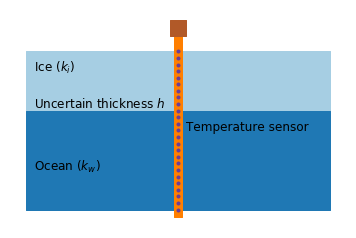

In [3]:
# visualize the domain
fig = plt.figure()
ax = plt.gca()
# color the ice
ax.fill_between(x, D-h_true, D, color='#a6cee3')
# color the ocean
ax.fill_between(x, 0.0, D-h_true, color='#1f78b4') 
# color the sensor
ax.fill_between(xsensor, 0.0-0.05*D, D+0.1*D, color='#ff7f00') 
# color the top of the sensor
ax.fill_between(2.0*xsensor, D+0.1*D, D+0.2*D, color='#b15928') 
# nodes that read the temperature
ax.plot([0]*n, zobs, 'o', markersize=3, color='#6a3d9a') 
# set plot parameters
ax.text(-0.95, 7.0, 'Ice ($k_i$)', fontsize=12)
ax.text(-0.95, 2.0, 'Ocean ($k_w$)', fontsize=12)
ax.text(-0.95, D-h_true+0.2, 'Uncertain thickness $h$', fontsize=12)
ax.text(0.05, D/2.0, 'Temperature sensor', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Step 3: forward model

For illustrative purposes, we will make a crude approximation of reality and model the temperture in the ice and water through the steady state heat equation.  This forward model is takes (potentially uncertain) parameters as input and predicts the vertical temperature profile.  

Let $h$ be the sea ice thickness, $k_i$ be the thermal conductivity of the sea ice, and $k_w$ be the thermal conductivity of the ocean.  The heat equation describes the vertical temperature profile $T(z)$ through:

\begin{equation}
   \frac{d}{d z}\left(k(z) \frac{d T}{d z} \right) = 0,
\end{equation}

for $z \in [0,D]$, where $k(z)$ is the thermal conductivity and takes the form 

\begin{equation}
    k(z) = \begin{cases}
        k_i & \mbox{if } z \leq h \\
        k_w & \mbox{if } z > h.
    \end{cases}
\end{equation}

The boundary conditions are

\begin{equation}
    \begin{array}{ccc}
        T(z=0) = T_{w} & \mbox{and} & \left. k_i \frac{\partial T}{\partial z}\right|_{z=D} = \tau \left(T_{a} - T(z=D)\right).
    \end{array}
\end{equation}

The first Dirichlet boundary condition assumes the temperature at the bottom of the domain (in the ocean) is $T_{w}$, which is known.  The second Robin boundary condition defines a flux into the domain from the atmosphere that is proportional to the difference between the air temperature $T_{a}$ and the ice temperature at the surface $T(z=D)$.  We assume the constant $\tau$ is also known.

Define $\theta = [k_i, k_w, h]$ to be the vector of uncertain parameters.  More generally, we could incorporate $T_{w}$, $T_{a}$ and/or $\tau$ into this vector and allow these parameters to also be uncertain.  For now, however, we assume $T_{w}$, $T_{a}$ and $\tau$ are known.

We can think of the forward model as a function $f: \mathbb{R}^3 \rightarrow \mathbb{R}^n$ that maps the three uncertain parameters to the temperature at the $n$ observation locations.

We have already defined the true ice thickness $h=3$, now lets define the true thermal conductivities $k_i=1$ and $k_w=5$.  We use the forward model to compute the vertical temperature profile given the true values.

The forward model defined in the `ForwardModel.py` file and then imported here as the `BuoyModel` class.  The first argument to the `BuoyModel` constructor is the vertical locations of the thermistor string and the second argument is the total thickness of the domain. 

(0.0, 8.0)

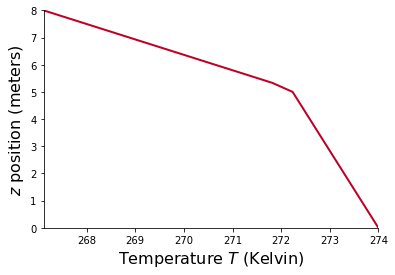

In [4]:
# true parameters
ki_true = 1.0
kw_true = 5.0
theta = [ki_true, kw_true, h_true]

# create the forward model object
model = BuoyModel(zobs, D)

# run the forward model given "true" parameter values
trueSoln = model.Evaluate([np.log(theta)]) [0]

# diagram showing the result (this will also show the ice/ocean layers and the measurement device)
fig = plt.figure()
ax = plt.gca()
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # forward model solution
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_xlim([trueSoln[-1], trueSoln[0]])
ax.set_ylim([zobs[0], zobs[-1]])

# Step 4: Prior information

Prior information incorporates information about the uncertain parameters due to physical constraints and expert knowledge.  We model this using a probability distribution, called the prior distribution, that is defined *before* observational data has been considered. 

In this case, the parameters must be positive ($k_i>0$, $k_w>0$, and $h>0$).  Therefore, we endow them with a log-Gaussin prior

\begin{equation}
    \begin{array}{cccc}
        \log{k_i} \sim N(\bar{k}_i, \sigma_{k_i}^2), & \log{k_w} \sim N(\bar{k}_w, \sigma_{k_w}^2), & \mbox{and} & \log{h} \sim N(\bar{h}, \sigma_h^2).
    \end{array}
\end{equation}

The hyperparameters $\bar{k}_i$, $\bar{k}_w$, and $\bar{h}$ are the mean of the log-Gaussian distributions and $\sigma_{k_i}^2$, $\sigma_{k_w}^2$, and $\sigma_{h}^2$ are the variances.  These are chosen by an expert to reflect 'reasonable' uncertainty based on literature and experience.  In this example, $\bar{k}_i = 0.9$, $\bar{k}_w=4.5$, and $\bar{h}=2.75$.

We denote the prior distribution over uncertian parameters as $\pi_{\Theta}$ and its probability density is 

\begin{equation}
    \pi_{\Theta}(\log{\theta}) = N(\log{\theta}; \bar{\theta}, \Sigma_{prior})
\end{equation}

where $\bar{\theta} = [\bar{k}_i, \bar{k}_w, \bar{h}]$ is the prior mean and $\Sigma_{prior} = \mbox{diag}\,[\sigma_{k_i}^2, \sigma_{k_w}^2, \sigma_{h}^2]$ is the prior covariance.


In [5]:
# define the hyperparameters
ki_bar = 0.9
kw_bar = 4.5
h_bar = 2.75
priorMean = np.log([ki_bar, kw_bar, h_bar]) # log-k_ice, log-k_water, log-thickness
sigma2_ki = 0.5
sigma2_kw = 1.0
sigma2_h = 0.75
priorVar = [sigma2_ki, sigma2_kw, sigma2_h] # prior variance

# define the prior probability density
prior = mm.Gaussian(priorMean, priorVar).AsDensity()

### Prior Predictive
We characeterize the *prior predictive distribution* by sampling $\theta^{(i)} \sim \pi_{\Theta}$ from the prior and then evaluating the forward model to get prior predicted temperature profiles $T^{(i)} = f(\theta^{(i)})$.

In [6]:
# generate 25 prior predicted temperature profiles                    
priorPredictiveSamples = [None]*25
for i in range(len(priorPredictiveSamples)):
    priorPredictiveSamples[i] = model.Evaluate([prior.Sample()]) [0]

Plot samples of the prior predictive.

(0.0, 8.0)

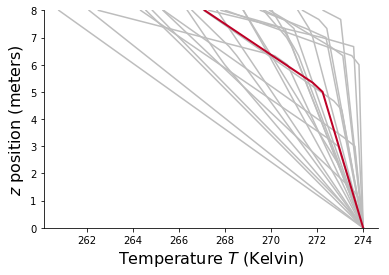

In [7]:
# show prior predictive
ax = plt.gca()

for samp in priorPredictiveSamples:
    ax.plot(samp, zobs, color='#bdbdbd') # true forward model solution
    
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # true forward model solution

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_ylim([zobs[0], zobs[-1]])

In this figure, the red line is the true vertical temperature profile and the grey lines are the foward model evaluated at prior samples.  Note that in practice, the true values will not be known.

# Step 5: Create Synthetic Data and Define Likelihood

After freezing the buoy into the ice, we would collect noisy observations of the vertical temperature profile.  We use these data, denoted here by $y$, to define the likelihood distribution, which models the probability of making observations $d$ given a parameter value $\theta$.

In our case, we do not have 'real' data.  Therefore, we will generate synthetic data by first evaluating the forward model at the true parameter values and then adding Gaussian noise so that  

\begin{equation}
    y = f(\theta_{true}) + \epsilon,
\end{equation}

where $\epsilon \sim N(0, \sigma_{y}^2 I)$.  For an additive error model like this one, the variance of the additive noise $\sigma_y^2$ represents many sources of uncertainty including model error, discretization error, and observations noise.  

The likelihood distribution $\pi_{Y \vert \Theta}$ uses the model-data mismatch to describe the likelihood of the data given the parameters and forward model.  We assume its probability density function is

\begin{equation}
    \pi_{Y \vert \Theta}(y \vert \theta) = N(y; f(\theta), \sigma_{y}^2 I) \propto \exp{\left(-\frac{1}{2\sigma_{y}^2} (f(\theta)-y)^T (f(\theta)-y)\right)}.
\end{equation}

We can think of the likelihood function $\mathcal{L}(\theta; d) = \log{\pi_{Y \vert \Theta}(y \vert \theta)}$ as a function of the uncertain parameters $\theta$.  

In the cell below, we generate a random sample of $\epsilon$ and use it to define synthetic "observations."

In [8]:
# hyperparameter for noise
sigy = 0.75 # variance

# add the noise to the true solution
noise = mm.Gaussian([0.0]*n, sigy*np.eye(n))
data = trueSoln+noise.Sample()

# define the likelihood function as a Gaussian centered at the data
likelihood = mm.Gaussian(data, sigy*np.ones(n)).AsDensity()

### Plot Synthetic Observations

(0.0, 8.0)

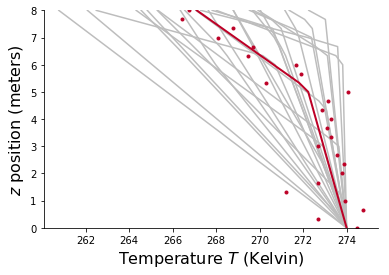

In [9]:
# show the data on top of prior predictive distribution
ax = plt.gca()

for samp in priorPredictiveSamples:
    ax.plot(samp, zobs, color='#bdbdbd') # forward model solution
    
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # true forward model solution
ax.plot(data, zobs, 'o', markersize=3, color='#bd0026') # data

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_ylim([zobs[0], zobs[-1]])

In this figure, the red line is the true vertical temperature profile and the grey lines are the foward model evaluated at prior samples.  The red dots are the noisy observations.

# Step 6: Define the Posterior

The posterior distribution $\pi_{\Theta \vert Y}$ describes our state of knowledge about the uncertain parameters $\theta$ given both observations $y$ *and* the prior distribution. Bayes' rule says that the posterior density is given by

\begin{equation}
    \pi_{\Theta \vert Y}(\theta \vert y) \propto \pi_{Y \vert \Theta}(y \vert \theta) \pi_{\Theta}(\theta)
\end{equation}

or, equivalently, 

\begin{equation}
    \log{\pi_{\Theta \vert Y}(\theta \vert y)} \propto \mathcal{L}(\theta; y) + \log{\pi_{\Theta}(\theta)}.
\end{equation}

MUQ allows us to compute the posterior density by breaking it into its components: the prior, the forward model, and the likelihood function.  We have already created these three components and only need to combine them according to Bayes' rule in order to define the posterior density.

To combine different model components, MUQ used a graph structure where each node in the graph represents one piece of the model (i.e., a "ModPiece") and edges represent dependencies between the pieces.

Below we construct a graph to define Bayes' rule.  Notice that each component could have multiple inputs and outputs, so we need to tell the `AddEdge` function which output and input to use.  For example, to connect output `n1` of a node named `'a'` to input `n2` of another node named `'b'`, we would call `AddEdge('a',n1, 'b', n2)`.

The `Visualize` function calls an external program called `dot` that is included with the `graphviz` package.  

In [10]:
# define the posterior via Bayes' rule
posterior = mm.DensityProduct(2)

# create the graph
graph = mm.WorkGraph()

# create a place holder object for the parameters
para = mm.IdentityOperator(3)

# add the nodes (each node is a component of the posterior)
graph.AddNode(para, 'parameters')
graph.AddNode(prior, 'prior')
graph.AddNode(likelihood, 'likelihood')
graph.AddNode(model, 'forward model')
graph.AddNode(posterior, 'posterior')

# connect the nodes
graph.AddEdge('parameters', 0, 'prior', 0)
graph.AddEdge('parameters', 0, 'forward model', 0)
graph.AddEdge('forward model', 0, 'likelihood', 0)
graph.AddEdge('likelihood', 0, 'posterior', 1) # first and only output of the likelihood to second input of posterior
graph.AddEdge('prior', 0, 'posterior', 0) # first and only output of the prior to the first input of the posterior

graph.Visualize('PosteriorGraph.png')

The `Visualize` function will produce an image "PosteriorGraph.png" that looks like this:

<img src="PosteriorGraph.png" alt="drawing" width="400"/>

The 'parameters' node represents the three unknown parameters.  These parameters and then given to the prior and forward model.  Finally, given the prior and likelihood, we can evaluate the posterior.

# Step 7: Sample the Posterior

In general, we cannot generate independent and identically distributed (iid) samples from the posterior distribution.   Markov chain Monte Carlo (MCMC) is one way to overcome this by generating *correlated* samples from the posterior distribution.

MCMC constructs a Markov chain whose stationary distribution is the posterior distribution.  As we take more MCMC steps the chain 'explores' the domain, spending more time in regions of higher posterior probability and less time in less likely regions.  By constructing the chain in the right way, we can guarantee that the Markov chain is ergodic, which ensures that states in the chain can be used as samples of the posterior distribution.  

To sample a distribution in MUQ, we first create a sampling problem.  This object exposes the target density to the MCMC sampler.  

In [11]:
# define the sampling problem
problem = ms.SamplingProblem(graph.CreateModPiece("posterior"))

MUQ has a variety of MCMC algorithms, most of which are a variation of a three step structure to generate the next state $\theta^{(t+1)}$ in the Markov chain given the current state $\theta^{(t)}$:

1.  For an appropriate proposal distribution $q_t$, sample $\theta^{\prime} \sim q_t(\cdot \vert \theta^{(t)})$
2.  Compute the acceptance probability $\alpha(\theta^{(t)}, \theta^{\prime})$
3.  Set $\theta^{(t+1)} = \theta^{\prime}$ with probability $\alpha(\theta^{(t)}, \theta^{\prime})$ (accept the proposal) and $\theta^{(t+1)} = \theta^{(t)}$ otherwise (reject the proposal).

These three steps define the transition kernel of the Markov chain.  In MUQ, we call this particular 3 step kernel the "Metropolis-Hastings Kernel" or `MHKernel` for short.  This kernel depends on the proposal distribution.

In the cell below, we will use the the Adaptive Metropolis algorithm, which follows these three steps, but adapts the proposal distribution $q_t$ based on previous samples.  In particular, the proposal takes the form of a Gaussian distribution

\begin{equation}
    q(\theta \vert \theta^{(t)}) = N(\theta; \theta^{(t)}, \Sigma_{proposal}),
\end{equation}

where the covariance is based on previous samples of the chain

\begin{equation}
    \Sigma_{proposal} = \sigma_a \mbox{cov}\,(x_{(1:t)}) + \epsilon I.
\end{equation}

This proposal has two parameters:

1.  The algorithm parameter $\epsilon$ is a small value to ensure that we can propose in any direction (typically $\epsilon \approx 10^{-10}$.
2.  The algorithm parameter $\sigma_a$ is the adaption scale (`AdaptScale`).  

In addition to these proposal samples, we also have a choice of how often to adapt the proposal covariance (`AdaptSteps`), how many steps should be taken before adapting (`AdaptStart`), and the variance of the proposal that should be used before adaptation begins (`ProposalVariance`).

To define the type of proposal and set additional parameters, the python bindings of MUQ use python dictionaries.  First, we define the propsal, which doesn't depend on any other object.

In [12]:
# create MCMC object
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1.0
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 100
proposalOptions['AdaptScale'] = 25.0

Once the proposal is defined, we can define the Metropolis-Hastings kernel, which depends on the proposal.

In [13]:
kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

Finally, we can define the complete MCMC algorithm.

In [14]:
options = dict()
options['NumSamples'] = 10000     # How many steps in the chain?
options['ThinIncrement'] = 1      # How often should the MCMC state be saved as a sample?
options['BurnIn'] = 0             # How many steps should be ignored before saving?
options['KernelList'] = 'Kernel'  # The name of another entry in the dictionary defining the kernel
options['PrintLevel'] = 3         # Set the verbosity of output {1,2,3}
options['Kernel'] = kernelOptions # Pass in the kernel dictionary

mcmc = ms.SingleChainMCMC(options, problem)

Next, we run MCMC to generate samples from the posterior distribution $\pi_{\Theta \vert Y}$.

In [15]:
# run MCMC with "good" parameters 
start = prior.Sample() # the first step of the Markov chain, chosen as a sample of the prior
posteriorSamps = mcmc.Run(start)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 1.6%
  20% Complete
    Block 0:
      Acceptance Rate = 1.1%
  30% Complete
    Block 0:
      Acceptance Rate = 1.4%
  40% Complete
    Block 0:
      Acceptance Rate = 1.2%
  50% Complete
    Block 0:
      Acceptance Rate = 1.4%
  60% Complete
    Block 0:
      Acceptance Rate = 1.7%
  70% Complete
    Block 0:
      Acceptance Rate = 1.7%
  80% Complete
    Block 0:
      Acceptance Rate = 1.6%
  90% Complete
    Block 0:
      Acceptance Rate = 1.7%
  100% Complete
    Block 0:
      Acceptance Rate = 1.7%
Completed in 82.3584 seconds.


## Diagonstics

MCMC needs to explore the entire domain.  The rate that the MCMC chain moves around the region of high posterior probability is called the mixing.  The acceptance rate is the rate is the frequency with which the proposal is accepted.  In the above run, the acceptance rate is very low $< 3 \%$.  The chain is very slowly moving around the domaing and, therefore, the mixing is slowl

We can plot the mixing by ploting the each state $\theta_i^{(t)}$ as a function of the MCMC step $t$.

In [16]:
# Extract a numpy matrix from the posterior sample collection
postSamps = posteriorSamps.AsMatrix()

Text(0.5,0,'MCMC step')

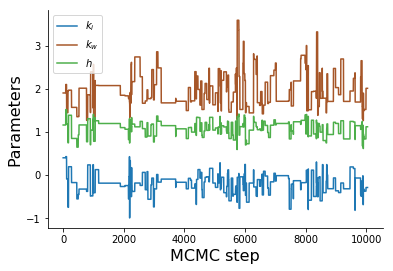

In [17]:
# Plot the trace of the chain 
ax = plt.gca()

colors = ['#1f78b4', '#a65628', '#4daf4a']
labels = ['$k_i$', '$k_w$', '$h$']

for color,label,samp in zip(colors,labels,postSamps):
    ax.plot(samp, color=color, label=label) # trace
    
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Parameters', fontsize=16)
ax.set_xlabel('MCMC step', fontsize=16)

Visually, the staircase structure in the trace indicates that few proposals are being accepted and the chain remains at the same location for many steps. It will therefore take a long time to explore the posterior.

We could solve this issue by running a longer chain, giving the chain a chance to explore the domain.  However, this is inefficient because each step of the chain requires one posterior density evaluation and thus one model evaluation.

Instead, we will fix this issue the algorithm parameters and rerunning the chain.

In [18]:
# change the adaptation scale
proposalOptions['AdaptScale'] = 0.01
mcmc = ms.SingleChainMCMC(options, problem)
posteriorSamps = mcmc.Run(start)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 71%
  20% Complete
    Block 0:
      Acceptance Rate = 80%
  30% Complete
    Block 0:
      Acceptance Rate = 83%
  40% Complete
    Block 0:
      Acceptance Rate = 84%
  50% Complete
    Block 0:
      Acceptance Rate = 86%
  60% Complete
    Block 0:
      Acceptance Rate = 87%
  70% Complete
    Block 0:
      Acceptance Rate = 87%
  80% Complete
    Block 0:
      Acceptance Rate = 87%
  90% Complete
    Block 0:
      Acceptance Rate = 87%
  100% Complete
    Block 0:
      Acceptance Rate = 87%
Completed in 80.8683 seconds.


The acceptance rate is now much higher.  However, the trace plot still suggests that MCMC is not exploring the domain.  Instead of seeing a staircase structure, we are now seeing very small steps that result in a meandering random walk around the domain.

Text(0.5,0,'MCMC step')

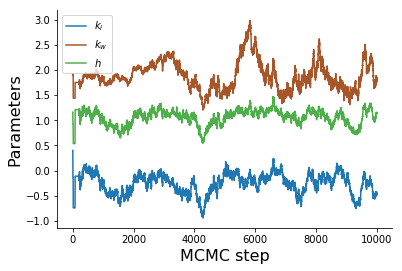

In [19]:
# Extract a numpy array
postSamps = posteriorSamps.AsMatrix()

# Create the trace plot
ax = plt.gca()

colors = ['#1f78b4', '#a65628', '#4daf4a']
labels = ['$k_i$', '$k_w$', '$h$']

for color,label,samp in zip(colors,labels,postSamps):
    ax.plot(samp, color=color, label=label) # trace
    
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Parameters', fontsize=16)
ax.set_xlabel('MCMC step', fontsize=16)

Now we are accepting frequently but the step size is very small.  The chain will need many of steps before it has explored the domain properly.  Again, we could fix this by running a longer chain, but this is ineffiecient.  Let's try to change the adaptation scale again.

When the adaptation scale was too large we took large, infrequent steps and when the adaptation scale was too small we took frequent small steps.  Let's try an intermediate value.

In [ ]:
# change the adaptation scale
proposalOptions['AdaptScale'] = 1.0
mcmc = ms.SingleChainMCMC(options, problem)
posteriorSamps = mcmc.Run(start)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 25%
  20% Complete
    Block 0:
      Acceptance Rate = 29%
  30% Complete
    Block 0:
      Acceptance Rate = 31%
  40% Complete
    Block 0:
      Acceptance Rate = 32%
  50% Complete
    Block 0:
      Acceptance Rate = 34%
  60% Complete
    Block 0:
      Acceptance Rate = 34%
  70% Complete
    Block 0:
      Acceptance Rate = 34%
  80% Complete
    Block 0:
      Acceptance Rate = 35%
  90% Complete
    Block 0:
      Acceptance Rate = 35%


In [ ]:
# Extract numpy array
postSamps = posteriorSamps.AsMatrix()

# Plot the trace
ax = plt.gca()

colors = ['#1f78b4', '#a65628', '#4daf4a']
labels = ['$k_i$', '$k_w$', '$h$']

for color,label,samp in zip(colors,labels,postSamps):
    ax.plot(samp, color=color, label=label) # trace
    
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Parameters', fontsize=16)
ax.set_xlabel('MCMC step', fontsize=16)

Now our acceptance rate is reasonable and the trace plot looks more like white noise, which means we are more efficiently exploring the posterior.

Although it is difficult to visualize a three dimensional distribution, we can plot the one and two dimensional marginal distributions.

In [ ]:
import pandas as pd

df = pd.DataFrame(postSamps.T, columns=['k_i', 'k_w', 'h'] )
pd.plotting.scatter_matrix(df, diagonal='kde', alpha=0.02, figsize=(8,8))

plt.show()

# Step 8: The Posterior Predictive Distribution

Now that we have used MCMC to generate samples from the posterior distribution, we can characterize the posterior predictive distribution by evaluating the forward model at the posterior samples $T^{(t)} = f(\theta^{(t)})$.  This is similar to the prior predictive distribution, except that the samples are now from the posterior.

Here, we randomly choose $25$ posterior samples to visualize the posterior predicitive distribution.

#### Generate Predictive Samples

In [ ]:
# compute the posterior predictive
posteriorPredictiveSamples = [None]*25

for i in range(len(posteriorPredictiveSamples)):
    ind = random.randint(0, posteriorSamps.size())
    posteriorPredictiveSamples[i] = model.Evaluate([[postSamps[0][ind], postSamps[1][ind], postSamps[2][ind]]]) [0]

#### Plot Predictive Samples

In [ ]:
ax = plt.gca()

for samp in posteriorPredictiveSamples:
    ax.plot(samp, zobs, color='#bdbdbd') # forward model solution
    
ax.plot(trueSoln, zobs, color='#bd0026', linewidth=2) # true forward model solution
ax.plot(data, zobs, 'o', markersize=3, color='#bd0026') # data

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$z$ position (meters)', fontsize=16)
ax.set_xlabel('Temperature $T$ (Kelvin)', fontsize=16)
ax.set_ylim([zobs[0], zobs[-1]])

plt.show()

Note that the posterior predictive distribution is much more concentrated around the true temperature profile.  This is because we have used the forward model and data to update our 'state of knowledge'.

# Why do we care?

* Probability distributions provide more information than just a "best estimate."  For example, we also know the mean and covariance. 
* Provides a robust way of determining how informative the data/observations are.
* We can propogate uncertainty through predictive models onto quantities of interest or future predictions.

# Conclusion

* We can combine different types of information to constrain uncertain parameter values.  
* Our state of knowledge is described by a probability distribution (e.g., prior and posterior).
* Sampling methods (e.g., MCMC) characterize the distribution.